# Implicit shape interpolation.

In this lab work we will focus on interpolating between shapes $\mathcal{S}_0$ and $\mathcal{S}_1$. We will make so using the Level Set Equation (see e.g. <a href="https://ieeexplore.ieee.org/abstract/document/938899">link</a>).
We now parameterize not only a single shape, but the whole path $F_\theta(x, t)$ between two shapes, i.e. $F_{\theta}(x, 0)$ is the SDF of the first shape $\mathcal{S}_0$ and $F_\theta(x, 1)$ is the SDF of the second shape $\mathcal{S}_1$

Given a temporal signed distance function $F_\theta(x, t)$, the level set equation encodes the motion of the level set following a prescribed vector field $V$ :
$$
\frac{\partial F(x, t)}{dt} + \langle \nabla F, V \rangle = 0
$$
with $F(x, 0)$ set to be the signed distance field of the initial shape $\mathcal{S}_0$.
It has been used with neural signed distance functions only in 2023 (<a href="https://openaccess.thecvf.com/content/ICCV2023/papers/Novello_Neural_Implicit_Surface_Evolution_ICCV_2023_paper.pdf"> link </a>). This lab will focus on replicating the code of the paper.

In [2]:
!jupyter server list
import torch

Currently running servers:
http://dgxa100:8889/ :: /raid/home/bournez_pie/mva_geom/mva_geom_24/TD6


In [3]:
# !wget https://www.lix.polytechnique.fr/~pierson/cours/TP6.zip

In [4]:
# !unzip -o TP6.zip
# !ls

In [5]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from slices import display_multi_slices, get_sdf_image
from tqdm.auto import tqdm
from synthetic_data import sphere_data, square_data
from marching_squares import get_img_marching_squares, display_multiple_shapes_sdf

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device="cpu"

## SIREN Neural network

The networks are built with <a href="https://arxiv.org/pdf/2006.09661">SIREN</a>. The network activation are sinusoidal functions, and a Siren layer is a network of the form
$$
\phi(x) = \sin(\omega_0*(W x + b))
$$

with $\omega_0 = 30$.

The network is initialized such that the first layer weight follow a $\mathcal{U}([-1/d_{in}, 1/d_{in}])$ (bias are initialized same), with $d_{in}$ the input feature, and the other follow a law $\mathcal{U}([-\frac{\sqrt{6/d_{in}}}{\omega_0}, \frac{\sqrt{6/d_{in}}}{\omega_0}])$.

In [6]:
class SirenLayer(nn.Module):
    def __init__(
        self, in_features, out_features, bias=True, is_first=False, omega_0=30
    ):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first

        self.in_features = in_features
        ## Create the layer, and initialize it. You can do it in init_weights

        self.fc1 = nn.Linear(in_features, out_features, bias=bias)
        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                ## Initialization of first layer type
                size = 1 / self.in_features
            else:
                size = np.sqrt(6 / self.in_features) / self.omega_0
                ## Other initialization
            self.fc1.weight.uniform_(-size, size)

    def forward(self, input):
        ## Logic
        return torch.sin(self.omega_0 * self.fc1(input))


input = torch.randn(2000, 3)
layer = SirenLayer(3, 256, is_first=True)
layer(input)

tensor([[ 0.9944,  0.8170, -0.6267,  ..., -0.1222,  0.8042, -0.0447],
        [-0.8115,  0.9200,  0.2936,  ..., -0.9968, -0.4306, -0.9558],
        [ 0.7779,  0.7570,  0.7585,  ..., -0.9992, -0.7500,  0.8987],
        ...,
        [ 0.8800,  0.8813,  0.2421,  ..., -0.5708, -0.5814, -0.9306],
        [ 0.8436, -0.8601, -0.7333,  ..., -0.9351,  0.9988, -0.9724],
        [-0.7258,  0.5251,  0.6326,  ...,  0.0480, -0.9595,  0.8446]],
       grad_fn=<SinBackward0>)

### Neural network logic
A siren network is of the form :
$$
\Phi(x) = W * (\phi_0  \circ \phi_1 \circ \phi_2 ....)(x) + b
$$

Build the network. The SIREN layers have constant output dimension hidden_dim. Optionnally, you can have skip connections on certain layers (you can ignore it for the beginning). Note that here, $x$ is in reality $x, t$ where $x$ is the coordinates in space and $t$ the coordinates in time.

In [7]:
class SirenNet(torch.nn.Module):
    def __init__(self, dim_in, dim_hidden, dim_out, num_layers, skip=[], omega_0=30.0):
        super().__init__()
        self.num_layers = num_layers
        self.dim_hidden = dim_hidden
        self.skip = [i in skip for i in range(num_layers)]
        self.omega_0 = omega_0
        layers_list = []
        ## Create layer
        # first layer
        layers_list.append(
            SirenLayer(
                in_features=dim_in,
                out_features=dim_hidden,
                is_first=True,
                omega_0=omega_0,
            )
        )
        for k in range(1, num_layers):
            layers_list.append(
                SirenLayer(
                    in_features=dim_hidden,
                    out_features=dim_hidden,
                    is_first=False,
                    omega_0=omega_0,
                )
            )
        ## Last layer is a simple linear layer. Don't forget to intialize your weights as before!
        self.skip.append(False)
        self.last_layer = nn.Linear(dim_hidden, dim_out, bias=True)
        ## Init last layer
        size = np.sqrt(6 / dim_in) / self.omega_0
        with torch.no_grad():
            self.last_layer.weight.uniform_(-size, size)
        # create the network
        self.layers = nn.ModuleList(layers_list)

    def forward(self, x):
        ## Network logic
        ## You can ignore skip connections at the beginning
        #! The skip is never initialized so we don't know what is exactly this parameters,
        #! we assume it's a list of index where we have to skip the connection

        for index, layer in enumerate(self.layers):
            if self.skip[index]:
                x = x + layer(x)
            else:
                x = layer(x)
        output = self.last_layer(x)
        return output


input = torch.randn(2000, 3, device=device)
net = SirenNet(dim_in=3, dim_hidden=256, dim_out=1, num_layers=5, skip=[]).to(device)
net(input)  #! BUG HERE

tensor([[-0.3640],
        [-0.4479],
        [-0.4271],
        ...,
        [-0.8104],
        [-0.4419],
        [-0.2850]], device='cuda:0', grad_fn=<AddmmBackward0>)

# Loss functions

A few loss functions are required to make the network work properly.

### Shape data attachement loss
The data attachement loss contains two terms. First the network should be $0$ on the shape:

$$
\mathcal{L}_{data} = \sum_{x \in \mathcal{S}_0} ||F_\theta(x, 0)||^2
$$

Second, the gradient of the SDF should be equal to the normal on the surface:

$$
\mathcal{L}_{normal} = \sum_{(x,n) \in \mathcal{S}_0} ||1 - \langle n, \nabla_\theta F_\theta(x, 0)||^2
$$

Write the code for $\mathcal{L}_{data}$

In [8]:
def loss_data(sdf_pc):
    return torch.mean(sdf_pc**2)  # ?

The computation of the gradient will be given. Write the code for $\mathcal{L}_{normal}$

In [9]:
def gradient(y, x, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad


def loss_normalign(grad_pc, sample_nc):
    first_ps = torch.sum(sample_nc * grad_pc, dim=1)
    return ((1 - first_ps) ** 2).mean()


grad_pc = torch.randn(2000, 2)
sample_nc = torch.randn(2000, 2)
loss_normalign(grad_pc, sample_nc)
grad_pc = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
sample_nc = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
loss_normalign(grad_pc, sample_nc)

tensor(0.)

Now, given pc, normals as input, and a batch_size, sample batch size points and return $100*\mathcal{L}_{data} + \mathcal{L}_{normal}$

In [10]:
def alternative_random_choice(
    array: "torch.tensor", size: int, replace: bool = False, shape: int = 0
):
    weights = torch.ones(array.shape[shape])

    idx = torch.multinomial(weights, size, replacement=replace)
    return idx


array = torch.randn(10, 2)
alternative_random_choice(array, 5)

tensor([2, 5, 8, 7, 3])

In [11]:
def loss_shape_data(net, pc, normals, batch_size=2000, dim_space=2):
    # sample batch size points and the corresponding normals
    idxs = alternative_random_choice(array=pc, size=batch_size, shape=0)
    sample_pc = pc[idxs]
    sample_pc.requires_grad = True
    sample_nc = normals[idxs]  #! Same idx !

    sdf_pc = net(sample_pc)
    # spatial gradients
    grad_pc = gradient(sdf_pc, sample_pc)[:, 0:2]

    ## compute loss
    loss_pc = 100 * loss_data(sdf_pc) + loss_normalign(grad_pc, sample_nc)
    return loss_pc


pc = torch.randn(10000, 3, device=device)
normals = torch.randn(10000, 2, device=device)
net = SirenNet(dim_in=3, dim_hidden=256, dim_out=1, num_layers=5).to(device)
loss_shape_data(net, pc, normals)

tensor(17.5930, device='cuda:0', grad_fn=<AddBackward0>)

### SDF data attachement loss
Like in deepSDF, we learn the SDF based on the ground truth SDF in ambient space (we suppose we have a way to compute it).

The loss is given as
$$
\mathcal{L}_{amb} =  \mathbb{E}_{x \sim X} [||F_\theta(x, 0) - \text{SDF}_{\text{gt}}(x)||²]
$$
where $X$ is the ambient space.

In practice, we have already sample points before as in previous lab. Code the loss function that randomly selects them and compute the loss. Return $10*\mathcal{L}_{amb}$

In [12]:
def loss_amb(net, pc_hint, gt_sdf, batch_size=2000):
    ## Sample random points in pc_hint and compute the SDF loss (as in previous lab but no clamp)
    idxs = alternative_random_choice(array=pc_hint, size=batch_size, shape=0)
    sample_pc = pc_hint[idxs]
    sample_pc.requires_grad = True
    sdf_pc = net(sample_pc).T[0]
    sample_gt_sdf = gt_sdf[idxs]
    loss_lamb = torch.mean((sdf_pc - sample_gt_sdf) ** 2)
    return 10 * loss_lamb


# pc_hint=torch.randn(10000,3,device=device)
# gt_sdf=torch.randn(10000,3,device=device)
# net=SirenNet(dim_in=3,dim_hidden=256,dim_out=3,num_layers=5).to(device)
# loss_amb(net,pc_hint,gt_sdf)

### Eikonal loss

The final loss is based on the fact that the SDF respects the eikonal equation (the gradient of the SDF is always one):
$$
||\nabla_x \text{SDF}_x || = 1
$$
The loss is given by:
$$
\mathbb{E}_{x, t} [|1-F(x, t)|]
$$
This expectation is approximated using a Monte Carlo estimation, at each step, points and time steps are sampled in the ambient space and we evaluate the sum at these points.

In [13]:
def loss_eikonal_pts(grad_pts):
    ## Get the eikonal loss given spatial gradients
    return torch.mean(torch.abs(torch.norm(grad_pts, dim=1) - 1))


grad_pts = torch.randn(100, 2, device=device)
print(loss_eikonal_pts(grad_pts))
grad_pts = torch.tensor([[0, 1]], dtype=torch.float32, device=device)
loss_eikonal_pts(grad_pts)
grad_pts = torch.tensor([[1, 1]], dtype=torch.float32, device=device)
loss_eikonal_pts(grad_pts)

tensor(0.6065, device='cuda:0')


tensor(0.4142, device='cuda:0')

In [14]:
torch.randn((200, 10, 10)).shape

torch.Size([200, 10, 10])

In [15]:
def sample_xt(batch_size, dim_space=2):
    ## Sample random points in space ([-1, 1]^2) and in time ([0, 1])
    list = [batch_size, dim_space]
    pts_random = (torch.rand(list, device=device)) * 2 - 1
    time_random = torch.rand(batch_size, device=device)

    return torch.cat((pts_random, time_random.view(-1, 1)), dim=1)


sample_xt(1000).max()

tensor(0.9999, device='cuda:0')

In [16]:
def loss_eikonal(net, batch_size, dim_space=2):
    ## Sample random points in space ([-1, 1]^2) and in time ([0, 1]), and compute eikonal loss
    pts_random = sample_xt(batch_size, dim_space)
    pts_random.requires_grad = True

    sdf_random = net(pts_random)

    grad_tot_random = gradient(sdf_random, pts_random)
    grad_spatial = grad_tot_random[:, 0:2]
    return loss_eikonal_pts(grad_spatial)


net = SirenNet(dim_in=3, dim_hidden=256, dim_out=3, num_layers=5).to(device)
loss_eikonal(net, 2000, 2)

tensor(2.7258, device='cuda:0', grad_fn=<MeanBackward0>)

### Levet set loss

In the case of a constant vector field, the equation reads as:

$$
\mathcal{L}_{lse} = \mathbb{E}_{(x, t)} [|| \frac{\partial F_\theta(x, t)}{\partial t} + \langle \nabla F_\theta(x, t), V \rangle||^2]
$$

This expectation is approximated using a Monte Carlo estimation, at each step, points and time steps are sampled in the ambient space and we evaluate the sum at these points.

In [17]:
def loss_lse_eq(net, vf, batch_size, dim_space=2):
    ## Sample random points in space ([-1, 1]^2) and in time ([0, 1]), and compute lse loss
    pts_random = sample_xt(batch_size, dim_space)
    pts_random.requires_grad = True

    sdf_random = net(pts_random)

    grad_tot_random = gradient(sdf_random, pts_random)
    # spatal gradient
    grad_random = grad_tot_random[:, 0:2]

    # temporal gradient
    tempgrad_random = grad_tot_random[:, 2]

    ## compute the loss
    loss_lse = torch.mean((tempgrad_random + grad_random @ vf) ** 2)
    return loss_lse

In [18]:
def evaluate_loss_cst_vf(
    net,
    pc,
    normals,
    hints_pc,
    gtsdf,
    vf,
    lpc,
    leik,
    lh,
    llse,
    lambda_pc=1,
    lambda_eik=2,
    lambda_hint=1,
    lambda_lse=1,
    batch_size=2000,
):
    # they are all at time 0 !

    # compute and store standard losses
    loss_pc = loss_shape_data(net, pc, normals, batch_size)

    loss_hint = loss_amb(net, hints_pc, gtsdf, batch_size)

    loss_eik = loss_eikonal(net, batch_size)

    loss_lse = loss_lse_eq(net, vf, batch_size)

    # append all the losses
    lpc.append(float(loss_pc))
    leik.append(float(loss_eik))
    lh.append(float(loss_hint))
    llse.append(float(loss_lse))

    # sum the losses of reach of this set of points
    loss = (
        lambda_pc * loss_pc
        + lambda_eik * loss_eik
        + lambda_hint * loss_hint
        + lambda_lse * loss_lse
    )

    return loss


pc_input = torch.randn(10000, 3, device=device)
normals = torch.randn(10000, 2, device=device)
hints_pc = torch.randn(100000, 3, device=device)
gtsdf = torch.randn(100000, device=device)
vf = torch.randn(2, device=device)
net = SirenNet(dim_in=3, dim_hidden=256, dim_out=1, num_layers=5).to(device)
lpc = []
leik = []
lh = []
llse = []
net = net.to(device)
evaluate_loss_cst_vf(net, pc_input, normals, hints_pc, gtsdf, vf, lpc, leik, lh, llse)

tensor(30.2883, device='cuda:0', grad_fn=<AddBackward0>)

In [19]:
def optimize_nise_vf(
    net,
    pc0,
    nc0,
    hints0,
    gtsdf0,
    vf,
    lpc,
    leik,
    lh,
    llse,
    lambda_pc=1,
    lambda_eik=2,
    lambda_hint=1,
    lambda_lse=2,
    batch_size=2000,
    nepochs=100,
    plot_loss=True,
):
    # pc0, nc0, hints0, gtsdf0 are the input data at time  0
    # vf is the velocity field
    # lpc, leik, lh, llse are lists to store the losses
    # lambda_pc, lambda_eik, lambda_hint, lambda_lse are the weights of the losses
    optim = torch.optim.Adam(params=net.parameters(), lr=2e-5)

    tinit = time.time()
    pbar = tqdm(total=nepochs, desc="Training")
    for batch in range(nepochs):
        optim.zero_grad()

        loss = evaluate_loss_cst_vf(
            net,
            pc0,
            nc0,
            hints0,
            gtsdf0,
            vf,
            lpc,
            leik,
            lh,
            llse,
            lambda_pc,
            lambda_eik,
            lambda_hint,
            lambda_lse,
            batch_size,
        )

        loss.backward()
        optim.step()
        if batch % 100 == 99 or batch == 0:
            # print(f"Epoch {batch}/{nepochs} - loss : {loss.item()}")
            pbar.set_postfix({"loss": loss.item()})
        pbar.update(1)

    tend = time.time()

    print("Optimizing NN took", "{:.2f}".format(tend - tinit), "s.")

### Data
We work for the moment on simple 2D canonical shapes for example a circle and a square, but feel free to test on your own shapes. You will need points sampled on the shape with their normals $(x_i, n_i)$ and point sampled in the ambient space with their groundtruth signed distances $(\text{hint}_j, \text{SDF}_{\text{GT}}(\text{hint}_j))$.

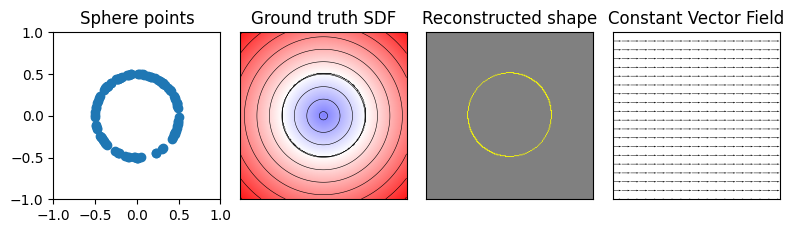

In [20]:
pc0, nc0, pts_hints0, gt_sdf_hints0, gt_grad_hints0, coords, sdf_coords = sphere_data(
    10000, 100000
)

# constant vector field (a single vector)
vf = torch.tensor([0.3, 0.0], device=device)


fig, axs = plt.subplots(1, 4, figsize=(8, 15))
pc_numpy = pc0.detach().cpu().numpy()
axs[0].scatter(pc_numpy[::100, 0], pc_numpy[::100, 1])
axs[0].set_aspect(1.0 / axs[0].get_data_ratio(), adjustable="box")
axs[0].set_xlim([-1, 1])
axs[0].set_ylim([-1, 1])
axs[0].set_title("Sphere points")
sdf_numpy = sdf_coords.detach().cpu().numpy()
axs[1].imshow(get_sdf_image(sdf_numpy))
axs[1].contour(sdf_numpy, 10, colors="k", linewidths=0.4, linestyles="solid")
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title("Ground truth SDF")
rec_img = get_img_marching_squares(sdf_numpy)
axs[2].imshow(rec_img)
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[2].set_title("Reconstructed shape")


def get_vector_field_meshgrid(X_value, Y_value):
    # Create a grid of points
    x = np.linspace(-1, 1, 20)
    y = np.linspace(-1, 1, 20)
    X, Y = np.meshgrid(x, y)

    # Define the constant vector field (e.g., constant vector [1, 1] everywhere)
    U = np.ones_like(X) * X_value / (10 * max(X_value, Y_value))  # constant x-component
    V = np.ones_like(Y) * Y_value / (10 * max(X_value, Y_value))  # constant y-component
    return X, Y, U, V


X, Y, U, V = get_vector_field_meshgrid(vf[0].item(), vf[1].item())
axs[3].quiver(X, Y, U, V, angles="xy", scale_units="xy", scale=1)
axs[3].set_xlim((-1, 1))
axs[3].set_ylim((-1, 1))
axs[3].set_aspect("equal")
axs[3].set_xticks([])
axs[3].set_yticks([])
axs[3].set_title("Constant Vector Field")
axs[3].grid()
plt.tight_layout()
plt.show()

Check that the eikonal loss is correct

In [21]:
print(loss_eikonal_pts(gt_grad_hints0).item())
np.isclose(loss_eikonal_pts(gt_grad_hints0).item(), 0)  ##Should be true

1.971125485056291e-08


False

Run the training and check the loss and results. We advice setting dim_hdden = 128, and a depth of 3 to start (faster). You can try improving the results later.

In [22]:
pc_t0 = torch.concat((pc0, torch.zeros((pc0.size(0), 1), device=device)), dim=1)
pts_hintst0 = torch.concat(
    (pts_hints0, torch.zeros((pts_hints0.size(0), 1), device=device)), dim=1
)
# this is the point clouds with the time dimension added

In [23]:
npl = 128
depth = 3
net = SirenNet(dim_in=3, dim_out=1, num_layers=depth, dim_hidden=npl, skip=[]).to(
    device
)
lpc, leik, lh, llse = [], [], [], []

pc_t0 = torch.concat((pc0, torch.zeros((pc0.size(0), 1), device=device)), dim=1)
pts_hintst0 = torch.concat(
    (pts_hints0, torch.zeros((pts_hints0.size(0), 1), device=device)), dim=1
)
nepochs = 5000
optimize_nise_vf(
    net,
    pc_t0,
    nc0,
    pts_hintst0,
    gt_sdf_hints0,
    vf,
    lpc,
    leik,
    lh,
    llse,
    nepochs=nepochs,
)
torch.save(net, "net_vf_{}_{}.net".format(npl, depth))

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Optimizing NN took 70.30 s.


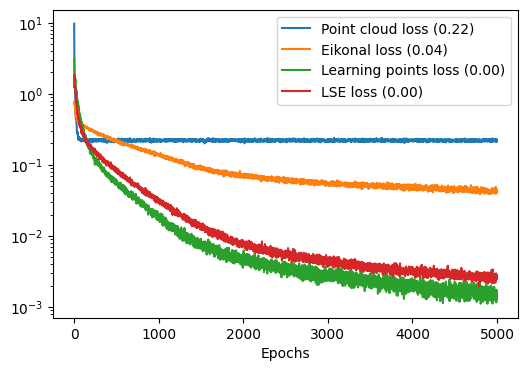

In [24]:
plt.figure(figsize=(6, 4))
plt.yscale("log")
plt.plot(lpc, label="Point cloud loss ({:.2f})".format(lpc[-1]))
plt.plot(leik, label="Eikonal loss ({:.2f})".format(leik[-1]))
plt.plot(lh, label="Learning points loss ({:.2f})".format(lh[-1]))
plt.plot(llse, label="LSE loss ({:.2f})".format(llse[-1]))
plt.xlabel("Epochs")
plt.legend()
plt.show()

## Results
We display the SDF and the resulting reconstructed shapes. You can find a potential example in the img/ folder

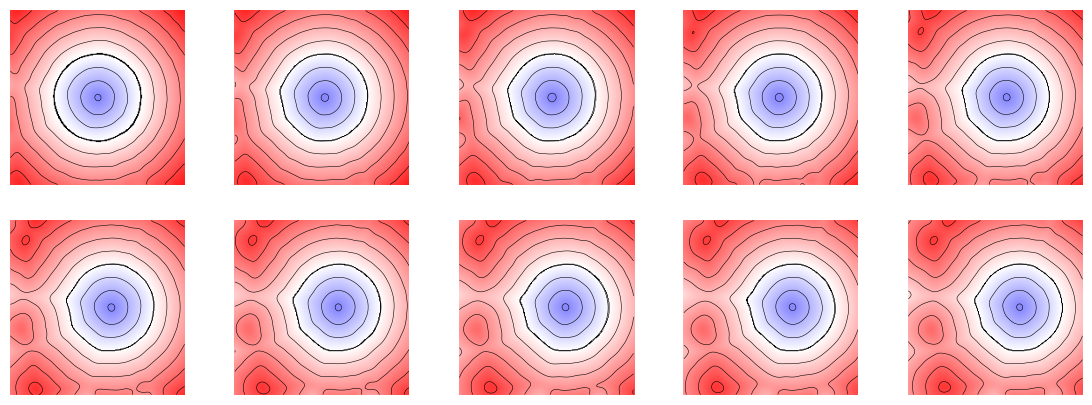

In [25]:
display_multi_slices(net, resolution=200, figsize=(14, 5))

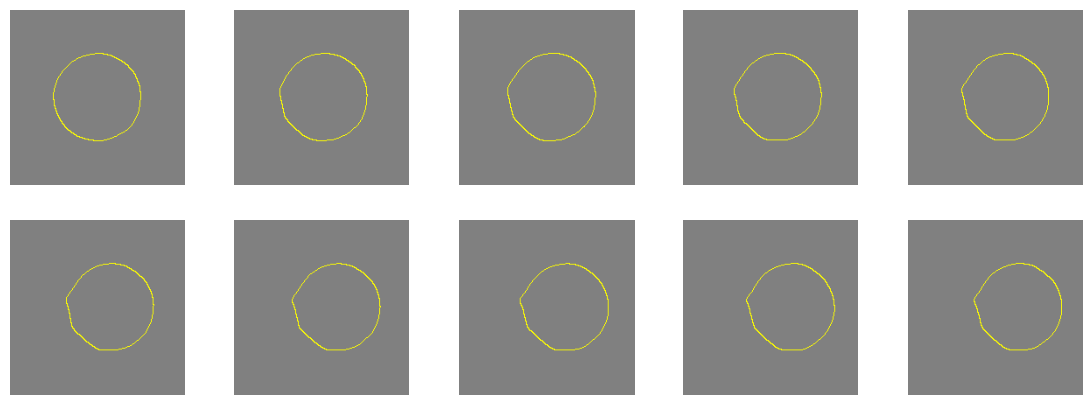

In [26]:
display_multiple_shapes_sdf(net, resolution=200, figsize=(14, 5))

## Morphing between shapes


The second test case consists into interpolate between two shapes, with signed distance functions $f_O$ at time 0 and $f_1$ at time 1. The vector field is not known in that case, but Novello et al. propose a simple and elegant solution, based on the following equality:
$$
V(x,t) = -(f_1(x) - F_{\theta}(x,t))\frac{\nabla F_{\theta}(x,t)}{\|\nabla F_{\theta}(x,t)\|}
$$
with
$$
F_{\theta}(x,0)=f_0(x)
$$

 Then by substitution in the LSE we have:
$$
\frac{\partial F_{\theta}(x,t)}{\partial t} - (f_1(x) - F_{\theta}(x,t))\|\nabla F_{\theta}(x,t)\| = 0
$$
and the loss:
$$
\mathcal L_{LSE}(\theta) = \mathbb{E}_{(x,t)}\Big[\Big\|\frac{\partial F_{\theta}(x,t)}{\partial t}- (f_1(x) - F_{\theta}(x,t))\|\nabla F_{\theta}(x,t)\|\Big\|^2\Big]
$$
Again the loss is evaluated using a Monte Carlo strategy

In [27]:
import os

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [28]:
import torch


def loss_lse_morph(net, pc_hint, gt_sdf, batch_size):
    # we assume gt_sdf is SDF AT TIME 1
    ## Sample batch size points with position hintspc, and add random time in [0, 1]
    n = len(pc_hint)
    indexes = torch.randint(n, size=(batch_size,), device=device)
    rd_pc = pc_hint[indexes, :2]  # We take down t=0
    rd_times = torch.rand(size=(batch_size, 1), device=device)
    random_hints = torch.concatenate([rd_pc, rd_times], dim=1)  #
    random_hints.requires_grad = True
    ## Evaluate SDF and gradient. Spatial gradient (nabla) is accessible via [:, 0:2], temporal derivative via [:, 2]
    sdf_random_hints = net(random_hints).squeeze()
    gt_sdf_sampled = gt_sdf[indexes]
    grad_tot_ = gradient(sdf_random_hints, random_hints)
    spatial_grad = grad_tot_[:, 0:2]
    # temporal gradient
    temp_deriv = grad_tot_[:, 2]
    # compute the loss
    norm = torch.norm(spatial_grad, dim=1)
    array_int = temp_deriv - (gt_sdf_sampled - sdf_random_hints) * norm
    l_lse = (array_int**2).mean()
    return l_lse


pc_hint = torch.randn(10000, 3, device=device)
gt_sdf = torch.randn(10000, device=device)
net = SirenNet(dim_in=3, dim_out=1, num_layers=2, dim_hidden=256, skip=[]).to(device)

loss_lse_morph(net, pc_hint, gt_sdf, 2000)

tensor(10.7616, device='cuda:0', grad_fn=<MeanBackward0>)

In [29]:
def evaluate_loss_morphing(
    net,
    pc0,
    normals0,
    hints_pc0,
    gtsdf0,
    pc1,
    normals1,
    hints_pc1,
    gtsdf1,
    lpc,
    leik,
    lh,
    llse,
    lambda_pc=100,
    lambda_eik=2e2,
    lambda_hint=1e2,
    lambda_lse=1e2,
    batch_size=2000,
):
    # compute and store standard losses
    loss_pc = loss_shape_data(net, pc0, normals0, batch_size) + loss_shape_data(
        net, pc1, normals1, batch_size
    )
    loss_hint = loss_amb(net, hints_pc0, gtsdf0, batch_size) + loss_amb(
        net, hints_pc1, gtsdf1, batch_size
    )

    loss_eik = loss_eikonal(net, batch_size)

    loss_lse = loss_lse_morph(net, hints_pc1, gtsdf1, batch_size)

    # append all the losses
    lpc.append(float(loss_pc))
    leik.append(float(loss_eik))
    lh.append(float(loss_hint))
    llse.append(float(loss_lse))

    # sum the losses of reach of this set of points
    loss = (
        lambda_pc * loss_pc
        + lambda_eik * loss_eik
        + lambda_hint * loss_hint
        + lambda_lse * loss_lse
    )

    return loss

### Interpolate between square and circle

In [30]:
# interpolate between a circle and a square
from synthetic_data import sphere_data, square_data
import matplotlib.pyplot as plt

nb_points = 10000
nb_points = 5000
pc0, nc0, pts_hints0, gt_sdf_hints0, gt_grad_hints0, _, sdf_coords0 = sphere_data(
    nb_points, nb_points
)
pc1, nc1, pts_hints1, gt_sdf_hints1, gt_grad_hints1, _, sdf_coords1 = square_data(
    nb_points, nb_points
)
print("pc1")

pc1


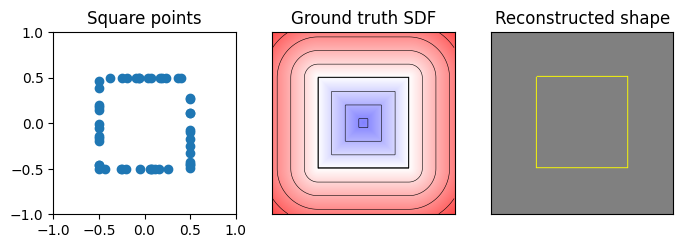

In [31]:
fig, axs = plt.subplots(1, 3, figsize=(8, 10))
pc_numpy = pc1.detach().cpu().numpy()
axs[0].scatter(pc_numpy[::100, 0], pc_numpy[::100, 1])
axs[0].set_aspect(1.0 / axs[0].get_data_ratio(), adjustable="box")
axs[0].set_xlim([-1, 1])
axs[0].set_ylim([-1, 1])
axs[0].set_title("Square points")
sdf_numpy = sdf_coords1.detach().cpu().numpy()
axs[1].imshow(get_sdf_image(sdf_numpy))
axs[1].contour(sdf_numpy, 10, colors="k", linewidths=0.4, linestyles="solid")
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title("Ground truth SDF")
rec_img = get_img_marching_squares(sdf_numpy)
axs[2].imshow(rec_img)
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[2].set_title("Reconstructed shape")
a = 1

In [32]:
def optimize_nise_morphing(
    net,
    pc0,
    nc0,
    pc1,
    nc1,
    hints0,
    gtsdf0,
    hints1,
    gtsdf1,
    lpc,
    leik,
    lh,
    llse,
    lambda_pc=1,
    lambda_eik=2,
    lambda_hint=1,
    lambda_lse=2,
    batch_size=2000,
    nepochs=100,
    plot_loss=True,
):
    optim = torch.optim.Adam(params=net.parameters(), lr=2e-5)
    # optim = torch.optim.LBFGS(params=net.parameters())
    tinit = time.time()
    pbar = tqdm(total=nepochs, desc="Training")
    for batch in range(nepochs):
        optim.zero_grad()

        loss = evaluate_loss_morphing(
            net,
            pc0,
            nc0,
            pc1,
            nc1,
            hints0,
            gtsdf0,
            hints1,
            gtsdf1,
            lpc,
            leik,
            lh,
            llse,
            lambda_pc,
            lambda_eik,
            lambda_hint,
            lambda_lse,
            batch_size,
        )

        loss.backward()
        optim.step()
        if batch % 100 == 99 or batch == 0:
            print(f"Epoch {batch}/{nepochs} - loss : {loss.item()}")
            pbar.set_postfix({"loss": loss.item()})
        pbar.update(1)

    tend = time.time()

    print("Optimizing NN took", "{:.2f}".format(tend - tinit), "s.")

In [33]:
# export cuda_launch blocking =1
import os

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [34]:
npl = 128
depth = 3
net_morph = SirenNet(dim_in=3, dim_out=1, num_layers=depth, dim_hidden=npl, skip=[]).to(
    device
)
lpc, leik, lh, llse = [], [], [], []

pc_t0 = torch.concat((pc0, torch.zeros((pc0.size(0), 1), device=device)), dim=1)
pc_t1 = torch.concat((pc1, 0.9 * torch.ones((pc1.size(0), 1), device=device)), dim=1)
pts_hintst0 = torch.concat(
    (pts_hints0, torch.zeros((pts_hints0.size(0), 1), device=device)), dim=1
)
pts_hintst1 = torch.concat(
    (pts_hints1, 0.9 * torch.ones((pts_hints1.size(0), 1), device=device)), dim=1
)

optimize_nise_morphing(
    net_morph,
    pc_t0,
    nc0,
    pts_hintst0,
    gt_sdf_hints0,
    pc_t1,
    nc1,
    pts_hintst1,
    gt_sdf_hints1,
    lpc,
    leik,
    lh,
    llse,
    nepochs=5000,
)

torch.save(net, "net_morph_{}_{}.net".format(npl, depth))

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch 0/5000 - loss : 18.62977409362793
Epoch 99/5000 - loss : 2.1064162254333496
Epoch 199/5000 - loss : 1.4505351781845093
Epoch 299/5000 - loss : 1.1066449880599976
Epoch 399/5000 - loss : 0.8776291608810425
Epoch 499/5000 - loss : 0.7049736976623535
Epoch 599/5000 - loss : 0.5934860110282898
Epoch 699/5000 - loss : 0.5539920926094055
Epoch 799/5000 - loss : 0.4899985194206238
Epoch 899/5000 - loss : 0.4548254907131195
Epoch 999/5000 - loss : 0.44005709886550903
Epoch 1099/5000 - loss : 0.42231693863868713
Epoch 1199/5000 - loss : 0.4184378981590271
Epoch 1299/5000 - loss : 0.39995867013931274
Epoch 1399/5000 - loss : 0.39998888969421387
Epoch 1499/5000 - loss : 0.385590136051178
Epoch 1599/5000 - loss : 0.3649647533893585
Epoch 1699/5000 - loss : 0.36382123827934265
Epoch 1799/5000 - loss : 0.3679104745388031
Epoch 1899/5000 - loss : 0.3468192517757416
Epoch 1999/5000 - loss : 0.3460659086704254
Epoch 2099/5000 - loss : 0.3443804979324341
Epoch 2199/5000 - loss : 0.3234769701957702

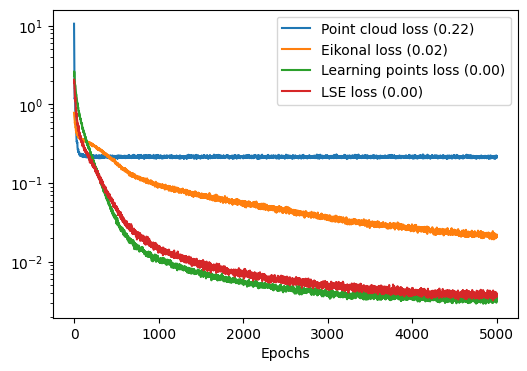

In [35]:
plt.figure(figsize=(6, 4))
plt.yscale("log")
plt.plot(lpc, label="Point cloud loss ({:.2f})".format(lpc[-1]))
plt.plot(leik, label="Eikonal loss ({:.2f})".format(leik[-1]))
plt.plot(lh, label="Learning points loss ({:.2f})".format(lh[-1]))
plt.plot(llse, label="LSE loss ({:.2f})".format(llse[-1]))
plt.xlabel("Epochs")
plt.legend()

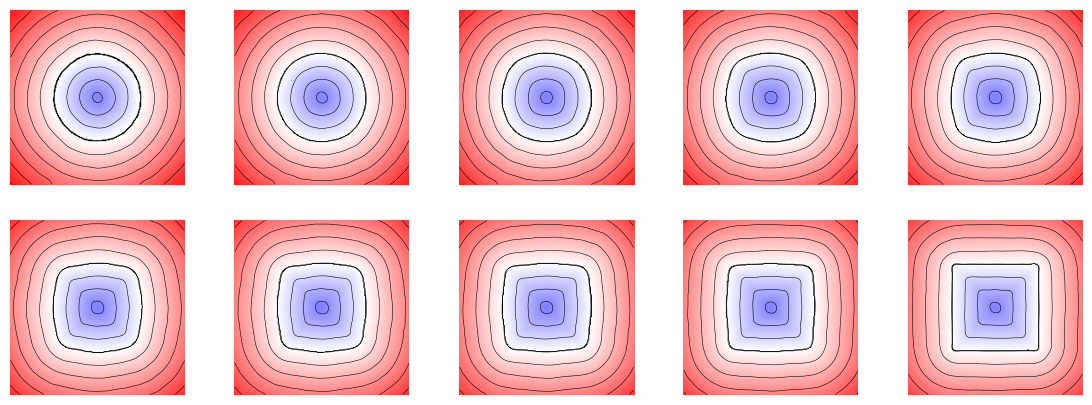

In [36]:
display_multi_slices(net_morph, resolution=200, figsize=(14, 5))

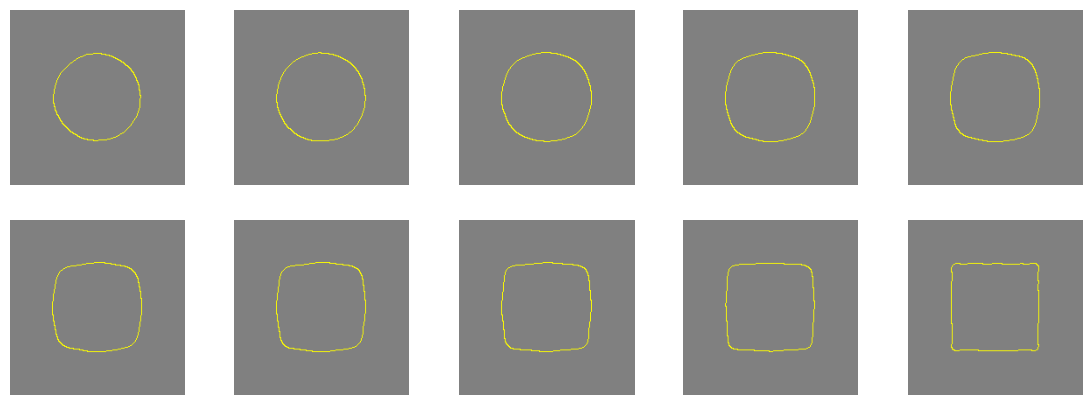

In [37]:
display_multiple_shapes_sdf(net_morph, resolution=200, figsize=(14, 5))

# Bonus: Interpolation of real shapes

Once the method is working (at least partially), try using real shapes. We suggest you to download an image from the following <a href=" https://2dshapesstructure.github.io/">website</a>.
Then you can extract the SDF by first extracting distances <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.distance_transform_edt.html">scipy.ndimage.distance_transform_edt</a>, and then find how to compute the <b>signed</b> distance field.

You can also extract the contour using scikit-image <a href="https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.find_contours">measure.find_contours</a> and compute the SDF as in previous TD. Good luck!